<a href="https://colab.research.google.com/github/mtsuka1999/data_study/blob/main/%E9%A3%9F%E3%81%B9%E3%83%AD%E3%82%B00104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考（【データ分析入門】知識ゼロから始めるためのデータ分析ガイド） https://data-viz-lab.com/data-analysis-intro

参考（Pythonでデータ分析〜ロジカルに「ええ店」を探す） https://note.com/natto_nebaneba/n/nedda4b7e8c9c

# **スクレイピング（検索タグ：神奈川県・デート）**

 ライブラリのインポート（おまじないだと思って下さい！）

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import os
import pandas as pd
import codecs
from urllib.parse import urljoin
import time
import numpy as np

In [2]:
#関数の定義
#URL内のレストラン名を取得
def get_restaurant_name(soup):
   restaurant = soup.find_all("a", class_="list-rst__rst-name-target cpy-rst-name js-ranking-num")
   return restaurant
   
#URL内の星の数を取得
def get_stars(soup):
   stars = pd.Series(soup.find_all("span", class_="c-rating__val c-rating__val--strong list-rst__rating-val"))
   stars = stars.apply(lambda x : str(x).replace("""<span class="c-rating__val c-rating__val--strong list-rst__rating-val">""",""))#不要な語句を消す
   stars = stars.apply(lambda x : str(x).replace("</span>",""))#不要な語句を消す
   return stars
   
#URL内の値段を取得
def get_dinner_price(soup):
   dinner_price = pd.Series(soup.find_all("span", class_="c-rating__val list-rst__budget-val cpy-dinner-budget-val"))
   dinner_price = dinner_price.apply(lambda x : str(x).replace("""<span class="c-rating__val list-rst__budget-val cpy-dinner-budget-val">￥""",""))#不要な語句を消す
   dinner_price = dinner_price.apply(lambda x : str(x).replace("</span>",""))#不要な語句を消す
   dinner_price = dinner_price.apply(lambda x : str(x).replace("￥",""))#不要な語句を消す
   return dinner_price

#URL内のレビュー数を取得
def get_review_number(soup):
   review_number =  pd.Series(soup.find_all("em", class_="list-rst__rvw-count-num cpy-review-count"))
   review_number = review_number.apply(lambda x : str(x).replace("""<em class="list-rst__rvw-count-num cpy-review-count">""",""))#不要な語句を消す
   review_number = review_number.apply(lambda x : str(x).replace("</em>",""))#不要な語句を消す
   return review_number

１ページ目のURLを変数にセット

In [3]:
start_url = "https://tabelog.com/kanagawa/A1401/rstLst/cond04-00-03/?SrtT=rt&Srt=D&sort_mode=1"

Beautifulsoup使ってURLの中の情報を取得

In [4]:
#BeautifulSoupのインスタンスを作る
start_r = requests.get(start_url)
start_soup = BeautifulSoup(start_r.text, "html.parser")

#確認
print(start_soup.prettify())

<!DOCTYPE html>
<html lang="ja">
 <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# article: http://ogp.me/ns/article#">
  <!--Google Tag Manager-->
  <script>
   (function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src='https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);})(window,document,'script','dataLayer','GTM-KVVB8K2');
  </script>
  <!--End Google Tag Manager-->
  <script src="//assets.adobedtm.com/3687940b53f7a560587a33c8bb748b9253ff5ea9/satelliteLib-15b13f3fd03e00e11fcd40b9f97c8b58a9ca6e66.js">
  </script>
  <meta charset="utf-8"/>
  <title>
   【デートにぴったり！】横浜のおすすめのグルメ情報 ランキング | 食べログ
  </title>
  <link href="https://s.tabelog.com/kanagawa/A1401/rstLst/cond04-00-03/?SrtT=rt" media="only screen and (max-width: 640px)" rel="alternate"/>
  <meta content="【Go To Eatキャンペーン開催中】日本最大級のグルメサイト「食べログ」では、横浜で人気のデ

空のリストを作って、

In [5]:
#ページ内の各要素を入れる空のリスト
restaurants_list = []#レストラン名
starts_list = []#星の数
dinner_price_list = []#ディナーの値段の文字列
review_number_list = []#レビュー数

１ページ目から取得した①店名、②星の数、③ディナーの値段、④レビュー数を一つずつリストに格納していく

In [6]:
#レストラン名を取得して一つずつリストに格納
restaurants = get_restaurant_name(start_soup)
for restaurant in restaurants:
   restaurants_list.append(restaurant)#取得したレストラン名をリストに格納

#星の数を取得して一つずつリストに格納
stars = get_stars(start_soup)
for star in stars:
   starts_list.append(star)#取得した星の数をリストに格納

#値段を取得して一つずつリストに格納
dinner_prices = get_dinner_price(start_soup)
for dinner_price in dinner_prices:
   dinner_price_list.append(dinner_price)#取得したディナーの値段をリストに格納

#コメント数を取得して一つずつリストに格納
reviews = get_review_number(start_soup)
for review in reviews:
   review_number_list.append(review)#取得したレビュー数をリストに格納

まず、開始ページ（=2）数と終わりのページをセット

In [7]:
#pageは2で固定
page = 2

#end_pageはエリアによって変える必要があります
end_page = 10

2ページ目から最後まで、一気にスクレイピング

In [8]:
while page <= end_page:
   taget_url = "https://tabelog.com/kanagawa/A1401/rstLst/cond04-00-03/1/?"+str(page)+"Srt=D&SrtT=rt&sort_mode=1"
   r = requests.get(taget_url)
   soup = BeautifulSoup(r.text, "html.parser")
   
   #レストラン名を取得して、リストに格納
   restaurants = get_restaurant_name(soup)
   for restaurant in restaurants:
       restaurants_list.append(restaurant)
       #print(restaurant)
               
   #星の数を取得してリストに格納
   stars = get_stars(soup)
   for star in stars:
       starts_list.append(star)
       
   #値段を取得してリストに格納
   dinner_prices = get_dinner_price(soup)
   for dinner_price in dinner_prices:
       dinner_price_list.append(dinner_price)

  #コメント数を取得してリストに格納
   comments = get_review_number(soup)
   for comment in comments:
       review_number_list.append(comment)

   print("page {} done!".format(page))
   page += 1#これがないと無限ループ
   time.sleep(5)#マナーとして
print("End")

page 2 done!
page 3 done!
page 4 done!
page 5 done!
page 6 done!
page 7 done!
page 8 done!
page 9 done!
page 10 done!
End


In [9]:
#確認
print(len(restaurants_list))
print(len(starts_list))
print(len(dinner_price_list))
print(len(review_number_list))

200
200
200
200


In [10]:
#空のデータフレームを作って
df = pd.DataFrame(columns=["restaurant","star","dinner_price","number_of_comments"])

#取得した各要素のリストをそれぞれ格納
df.restaurant = restaurants_list
df.star = starts_list
df.dinner_price = dinner_price_list
df.number_of_comments = review_number_list


In [11]:
#確認
df.dtypes
#扱いやすいように列の型を変更
df.restaurant = df.restaurant.apply(lambda x : str(x))
df.star = df.star.astype("float")
df.number_of_comments = df.number_of_comments.astype("int")
#restaurant列を列内で分割して新しい変数df2に格納
df2 = df.restaurant.str.split(">",expand=True)

#不要な列を削除
df2.columns = ["unnecessary","name","unnecessary2"]
df2 = df2.drop(["unnecessary","unnecessary2"],axis=1)

#不要な語句の削除と加工
df2.name = df2.name.str.replace("</a","")
df2.name = df2.name.str.replace(" ","_")#半角スペースをアンスコに
df2.name = df2.name.str.replace("　","_")#全角スペースをアンスコに

#確認
df2

,name
0,萬珍樓點心舗
1,焼鳥_美鶏
2,RISTORANTE_REGA
3,トラットリア_フランコ
4,リオス_ボングスタイオ
...,...
195,カサ・デ・フジモリ
196,鶏料理・焼きとり_纜
197,ヴェルヴェンヌ
198,きむら


In [12]:
#元のデータフレーム（df）と結合させて、元のrestaurant列は削除
df = pd.concat([df,df2],axis=1).drop("restaurant",axis=1)

#確認
df.head()

,star,dinner_price,number_of_comments,name
0,3.77,"6,000～7,999",416,萬珍樓點心舗
1,3.74,"5,000～5,999",145,焼鳥_美鶏
2,3.72,"8,000～9,999",127,RISTORANTE_REGA
3,3.71,"5,000～5,999",220,トラットリア_フランコ
4,3.71,"6,000～7,999",97,リオス_ボングスタイオ


In [13]:
#スクレイピング過程で変な値が入ってるのがありそう。
df.dinner_price.unique()

array(['6,000～7,999', '5,000～5,999', '8,000～9,999', '3,000～3,999',
       '10,000～14,999', '4,000～4,999'], dtype=object)

In [14]:
#正常なレコードだけdfに格納し直し
df = df[df.dinner_price != """<span class="c-rating__val list-rst__budget-val cpy-dinner-budget-val">-"""]

ディナーの値段列を扱いやすいように加工

In [15]:
#~の文字で列内を分割して、df3に一旦格納
df3 = df.dinner_price.str.split("～",expand=True)
df3.columns = ["lower","higher"]

#値段の文字列のカンマを消す
df3.lower = df3.lower.str.replace(",","")
df3.higher = df3.higher.str.replace(",","")

#値段の文字列を整数に型を変換
df3.lower = df3.lower.astype(int)
df3.higher = df3.higher.astype(int)

#元のデータフレームにくっつける
df = pd.concat([df,df3],axis=1)

#値段の上限の方が~999なので1足す（足さなくてもいいけど）
df.higher = df.higher+1

#下限と上限の平均を出しておく
df["dinner_average"] = (df3.lower + df3.higher)/2

#確認
df.head()

,star,dinner_price,number_of_comments,name,lower,higher,dinner_average
0,3.77,"6,000～7,999",416,萬珍樓點心舗,6000,8000,6999.5
1,3.74,"5,000～5,999",145,焼鳥_美鶏,5000,6000,5499.5
2,3.72,"8,000～9,999",127,RISTORANTE_REGA,8000,10000,8999.5
3,3.71,"5,000～5,999",220,トラットリア_フランコ,5000,6000,5499.5
4,3.71,"6,000～7,999",97,リオス_ボングスタイオ,6000,8000,6999.5


#グラフを作って「ちょうどええ店」を探す

In [ ]:
#ライブラリのimport

import matplotlib.pyplot as plt
import seaborn as sns

#seaborn色の設定
sns.set_style('whitegrid')

#matplotlibをインライン表示
%matplotlib inline

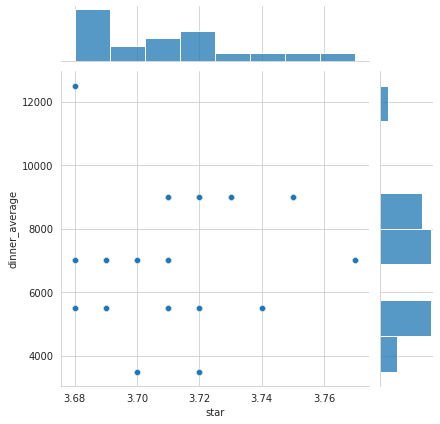

In [ ]:
#【星の数】と【ディナーの値段】で散布図

sns.jointplot(x = "star", y = "dinner_average",data= df)

In [ ]:
#レビュー数によってデータセットを分割する

#レビュー数が平均以上あるグループ
above_average  = df[df.number_of_comments >= df.number_of_comments.mean()]

#レビュー数が平均以下あるグループ
below_average  = df[df.number_of_comments <= df.number_of_comments.mean()]

#レビュー数が30件以下のグループ
under_30reviews  = df[df.number_of_comments <= 30]

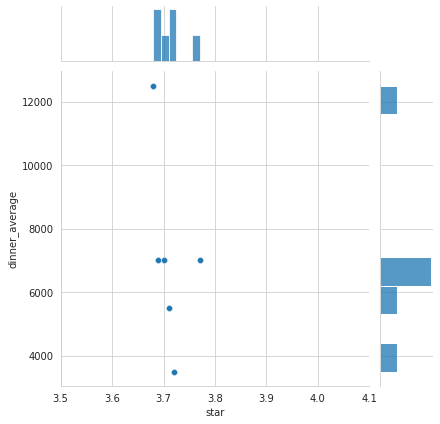

In [ ]:
#それぞれ可視化

sns.jointplot(x = "star", y = "dinner_average",data= above_average, xlim=(3.5,4.1))

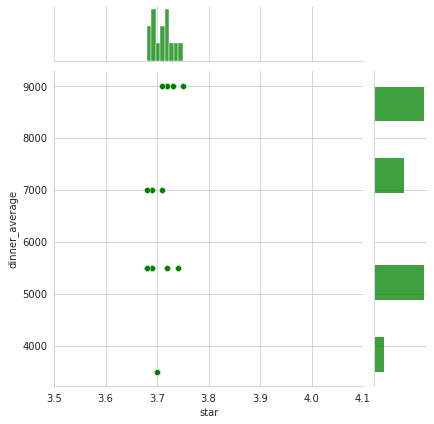

In [ ]:
sns.jointplot(x = "star", y = "dinner_average",data= below_average, color="green",xlim=(3.5,4.1))

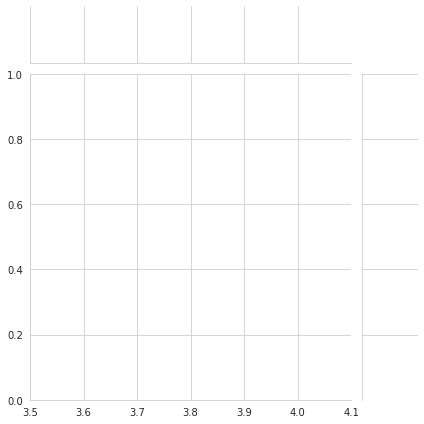

In [ ]:
sns.jointplot(x = "star", y = "dinner_average",data= under_30reviews, color="red",xlim=(3.5,4.1))

In [ ]:
above_average[(above_average.dinner_average <= 5000) & (above_average.star >=3.6)]

,star,dinner_price,number_of_comments,name,lower,higher,dinner_average
4,3.72,"3,000～3,999",260,レストラン_ラ・マーレ,3000,4000,3499.5
24,3.72,"3,000～3,999",260,レストラン_ラ・マーレ,3000,4000,3499.5
44,3.72,"3,000～3,999",260,レストラン_ラ・マーレ,3000,4000,3499.5
64,3.72,"3,000～3,999",260,レストラン_ラ・マーレ,3000,4000,3499.5
84,3.72,"3,000～3,999",260,レストラン_ラ・マーレ,3000,4000,3499.5


#結論


横浜市周辺でデートにいいのは[トラットリア_ダ・テレーサ](https://tabelog.com/kanagawa/A1401/A140207/14042586/)

余談ですが、、、、
個人的にデートにおすすめの店は横浜駅西口近くの
 [OSTERIA il FUOCO](https://tabelog.com/kanagawa/A1401/A140102/14051993/)です。リア充や落としたい人がいるひとは是非！！笑



